In [19]:
import pandas as pd
import scipy.special
import math
from matplotlib.pyplot import plot,scatter
import statistics
from sklearn.cluster import KMeans
from kneed import KneeLocator
import matplotlib.pyplot as plt
import numpy as np

nba 2000 Indiana Pacers -5.631077324079996
nba 2001 Denver Nuggets -5.610862267082693
nba 2002 New Jersey Nets -4.228697343452214
nba 2003 Chicago Bulls -8.914917337805443
nba 2004 Dallas Mavericks -7.648357773084604
nba 2005 San Antonio Spurs -6.846028544961502
nba 2006 Orlando Magic -4.676365219094853
nba 2007 Golden State Warriors -5.661837441662076
nba 2008 Utah Jazz -8.016702264422117
nba 2009 Utah Jazz -5.966234135382336
nba 2010 Charlotte Bobcats -5.736040780142513
nba 2011 Washington Wizards -5.555142475073601
nba 2012 Utah Jazz -4.595523957659505
nba 2013 Denver Nuggets -7.929267254368207
nba 2014 Orlando Magic -4.65226216045649
nba 2015 Golden State Warriors -4.345799270948383
nba 2016 San Antonio Spurs -5.9627547043522755
nba 2017 Indiana Pacers -4.7275519246970665
nba 2018 San Antonio Spurs -6.4493585127408375
nba 2019 San Antonio Spurs -4.941070454782477
nba 2020 Philadelphia 76ers -8.91207340615599
mlb 2000 NYM -3.1183210435371995
mlb 2001 FLA -3.29193685603975
mlb 2002 C

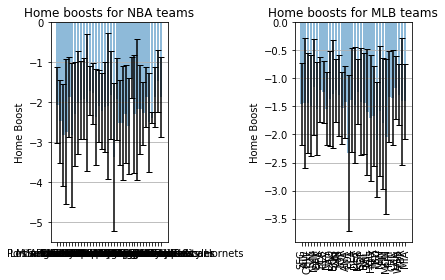

In [35]:
years = range(2000, 2021)
leagues = ["nba", "mlb"] # TODO: add other leagues

def get_home_boost(total_pct, home_wins, home_games):
    prob = 0
    for wins in range(math.ceil(home_wins), home_games + 1):
        prob += scipy.special.binom(home_games, wins) * total_pct ** wins * (1-total_pct) ** (home_games - wins)
        
    return math.log(prob)

teamHomeBoosts={}
for league in leagues:
    teamHomeBoosts[league]={}
    for year in years:
        min_team = ""
        min_boost = 0
        
        standings = pd.read_csv("data/" + league + "/" + str(year) + ".csv") 
        for (team, home, road) in zip(standings["Team"], standings["Home"], standings["Road"]):
            [home_wins, home_losses] = [int(games) for games in home.split("-")]
            [road_wins, road_losses] = [int(games) for games in road.split("-")]

            total_wins = home_wins + road_wins
            total_games = total_wins + home_losses + road_losses

            total_pct = total_wins / total_games

            home_games = home_wins + home_losses
            
            boost = get_home_boost(total_pct, home_wins, home_games)
            
            if(team not in teamHomeBoosts[league]):
                teamHomeBoosts[league][team]=[]
            teamHomeBoosts[league][team].append(boost)
            
            if boost < min_boost:
                min_team = team
                min_boost = boost
        print(league, year, min_team, min_boost)
        
nba = teamHomeBoosts["nba"]
nba_labels = []
nba_means = []
nba_std_devs = []
for key in nba:
    nba_labels.append(key)
    nba_means.append(statistics.mean(nba[key]))
    nba_std_devs.append(statistics.pstdev(nba[key]))
    
mlb = teamHomeBoosts["mlb"]
mlb_labels = []
mlb_means = []
mlb_std_devs = []
for key in mlb:
    mlb_labels.append(key)
    mlb_means.append(statistics.mean(mlb[key]))
    mlb_std_devs.append(statistics.pstdev(mlb[key]))



#References https://pythonforundergradengineers.com/python-matplotlib-error-bars.html
fig, (ax1,ax2) = plt.subplots(1,2)

x_pos1 = np.arange(len(nba_labels))
ax1.bar(x_pos1, nba_means, yerr=nba_std_devs, align='center', alpha=0.5, ecolor='black', capsize=3)
ax1.set_ylabel('Home Boost')
ax1.set_xticks(x_pos1)
ax1.set_xticklabels(nba_labels)
plt.xticks(rotation='vertical')
ax1.set_title('Home boosts for NBA teams')
ax1.yaxis.grid(True)

x_pos2 = np.arange(len(mlb_labels))
ax2.bar(x_pos2, mlb_means, yerr=mlb_std_devs, align='center', alpha=0.5, ecolor='black', capsize=3)
ax2.set_ylabel('Home Boost')
ax2.set_xticks(x_pos2)
ax2.set_xticklabels(mlb_labels)
#plt.xticks(rotation='vertical')
ax2.set_title('Home boosts for MLB teams')
ax2.yaxis.grid(True)

# Save the figure and show
plt.tight_layout()
plt.savefig('bar_plot_with_error_bars.png')
plt.show()

    

In [29]:
other_years = range(2000, 2020)
other_leagues = ["nfl", "nhl"] # TODO: add other leagues

for league in other_leagues:
    teamHomeBoosts[league]={}
    for year in other_years:
        if league == "nhl" and year == 2005:
            continue
        
        min_team = ""
        min_boost = 0
        
        standings = pd.read_csv("data/" + league + "/" + str(year) + ".csv") 
        for (team, games, wins, home_games, home_wins) in zip(standings["Team"], standings["Games"], standings["Wins"], standings["Home Games"], standings["Home Wins"]):
            total_pct = wins / games
            
            boost = get_home_boost(total_pct, home_wins, home_games)
            
            if(team not in teamHomeBoosts[league]):
                teamHomeBoosts[league][team]=[]
            teamHomeBoosts[league][team].append(boost)
            
            if boost < min_boost:
                min_team = team
                min_boost = boost
        print(league, year, min_team, min_boost)     
        
    

nfl 2000 Arizona Cardinals -1.7359465419824767
nfl 2001 Minnesota Vikings -2.6845894198294498
nfl 2002 Miami Dolphins -2.625750466669077
nfl 2003 Seattle Seahawks -3.7600290339658846
nfl 2004 Arizona Cardinals -1.9847931707052622
nfl 2005 Baltimore Ravens -3.3236384462947344
nfl 2006 Indianapolis Colts -2.301456579614247
nfl 2007 Pittsburgh Steelers -2.002171116413511
nfl 2008 Carolina Panthers -2.301456579614247
nfl 2009 New England Patriots -3.7600290339658846
nfl 2010 Green Bay Packers -2.002171116413511
nfl 2011 Baltimore Ravens -2.301456579614247
nfl 2012 Seattle Seahawks -2.9975475955312856
nfl 2013 Cincinnati Bengals -2.9975475955312856
nfl 2014 Green Bay Packers -2.301456579614247
nfl 2015 Jacksonville Jaguars -1.5260741550126662
nfl 2016 Houston Texans -2.625750466669077
nfl 2017 New York Jets -1.5260741550126662
nfl 2018 New England Patriots -2.9975475955312856
nfl 2019 New York Jets -1.4395875229796313
nhl 2000 Pittsburgh Penguins -1.9908276130136056
nhl 2001 Tampa Bay Light

In [ ]:
#Are there teams out of all leagues which consistently enjoy a larger home boost?
def computeOptimalClusters(testList):
    xList=[]
    yList=[]
    length=len(tuple(testList))
    list2=[]
    for i in range(1,length+1,1):
        cluster=KMeans(n_clusters=i)
        fit=cluster.fit(testList)
        list2.append([fit.inertia_, i])
    for i in list2:
        xList.append(i[1])
        yList.append(i[0])
    kn = KneeLocator(xList, yList, curve='convex', direction='decreasing')
    print(kn.knee)
    return(kn.knee)

def evaluateConsistency(testList):
    cluster=KMeans(n_clusters=computeOptimalClusters(testList), max_iter=10000, tol=.000000001,algorithm='auto')
    cluster.fit(testList)
    MeasureList=cluster.predict(testList)
    scatter([i[0] for i in testList],[i[1] for i in testList],c=MeasureList)
    minimum=min([index[1] for index in cluster.cluster_centers_])
    minIndex=[i for i in range(0,len(cluster.cluster_centers_)) if cluster.cluster_centers_[i][1]==minimum]
    selectList=[]
    for index,point in zip(MeasureList,testList):
        if(index==minIndex):
            selectList.append(point)
    return selectList

consistencyDict={}
consistencyList=[]
for league in teamHomeBoosts:
    for team in teamHomeBoosts[league]:
        if(len(teamHomeBoosts[league][team])>=2):
            variance=statistics.variance(teamHomeBoosts[league][team])
        
            mean=statistics.mean(teamHomeBoosts[league][team])
            if(mean<=0):
                consistencyDict[team]=[mean,variance]
                consistencyList.append([mean,variance])

meanSet=statistics.mean([item[0] for item in consistencyList])
print(meanSet)
greaterMeanList=[item for item in consistencyList if item[0]<meanSet]
lesserMeanList=[item for item in consistencyList if item[0]>meanSet]
consistentValuesLesser=evaluateConsistency(lesserMeanList)
consistentValuesGreater=evaluateConsistency(greaterMeanList)
print("Consistent high home boosts: ")
for i in consistentValuesGreater:
    print(i,list(consistencyDict.keys())[list(consistencyDict.values()).index(i)])
print("Consistent low home boosts: ")
for i in consistentValuesLesser:
    print(i,list(consistencyDict.keys())[list(consistencyDict.values()).index(i)])






In [ ]:
#which teams in the nba enjoy consistent higher and lower home boosts?
consistencyDict={}
consistencyList=[]

for team in teamHomeBoosts["nba"]:
    if(len(teamHomeBoosts["nba"][team])>=2):
        variance=statistics.variance(teamHomeBoosts["nba"][team])
        mean=statistics.mean(teamHomeBoosts["nba"][team])
        if(mean<=0):
            consistencyDict[team]=[mean,variance]
            consistencyList.append([mean,variance])
                                   
                                   
scatter([index[0] for index in consistencyList],[index[1] for index in consistencyList])

meanSet=statistics.mean([item[0] for item in consistencyList])
print(meanSet)
greaterMeanList=[item for item in consistencyList if item[0]<meanSet]
lesserMeanList=[item for item in consistencyList if item[0]>meanSet]
consistentValuesLesser=evaluateConsistency(lesserMeanList)
consistentValuesGreater=evaluateConsistency(greaterMeanList)
print("Consistent high home boosts: ")
for i in consistentValuesGreater:
    print(i,list(consistencyDict.keys())[list(consistencyDict.values()).index(i)])
print("Consistent low home boosts: ")
for i in consistentValuesLesser:
    print(i,list(consistencyDict.keys())[list(consistencyDict.values()).index(i)])


In [ ]:
#which teams in the mlb enjoy consistent higher and lower home boosts?
consistencyDict={}
consistencyList=[]

for team in teamHomeBoosts["mlb"]:
    if(len(teamHomeBoosts["mlb"][team])>=2):
        variance=statistics.variance(teamHomeBoosts["mlb"][team])
        mean=statistics.mean(teamHomeBoosts["mlb"][team])
        if(mean<=0):
            consistencyDict[team]=[mean,variance]
            consistencyList.append([mean,variance])
                                   
                                   
scatter([index[0] for index in consistencyList],[index[1] for index in consistencyList])

meanSet=statistics.mean([item[0] for item in consistencyList])
print(meanSet)
greaterMeanList=[item for item in consistencyList if item[0]<meanSet]
lesserMeanList=[item for item in consistencyList if item[0]>meanSet]
consistentValuesLesser=evaluateConsistency(lesserMeanList)
consistentValuesGreater=evaluateConsistency(greaterMeanList)
print("Consistent high home boosts: ")
for i in consistentValuesGreater:
    print(i,list(consistencyDict.keys())[list(consistencyDict.values()).index(i)])
print("Consistent low home boosts: ")
for i in consistentValuesLesser:
    print(i,list(consistencyDict.keys())[list(consistencyDict.values()).index(i)])

In [ ]:
#which teams in the nfl enjoy consistent higher and lower home boosts?
consistencyDict={}
consistencyList=[]

for team in teamHomeBoosts["nfl"]:
    if(len(teamHomeBoosts["nfl"][team])>=2):
        variance=statistics.variance(teamHomeBoosts["nfl"][team])
        mean=statistics.mean(teamHomeBoosts["nfl"][team])
        if(mean<=0):
            consistencyDict[team]=[mean,variance]
            consistencyList.append([mean,variance])
                                   
                                   
scatter([index[0] for index in consistencyList],[index[1] for index in consistencyList])

meanSet=statistics.mean([item[0] for item in consistencyList])
print(meanSet)
greaterMeanList=[item for item in consistencyList if item[0]<meanSet]
lesserMeanList=[item for item in consistencyList if item[0]>meanSet]
consistentValuesLesser=evaluateConsistency(lesserMeanList)
consistentValuesGreater=evaluateConsistency(greaterMeanList)
print("Consistent high home boosts: ")
for i in consistentValuesGreater:
    print(i,list(consistencyDict.keys())[list(consistencyDict.values()).index(i)])
print("Consistent low home boosts: ")
for i in consistentValuesLesser:
    print(i,list(consistencyDict.keys())[list(consistencyDict.values()).index(i)])

In [ ]:
#which teams in the nhl enjoy consistent higher and lower home boosts?
consistencyDict={}
consistencyList=[]

for team in teamHomeBoosts["nhl"]:
    if(len(teamHomeBoosts["nhl"][team])>=2):
        variance=statistics.variance(teamHomeBoosts["nhl"][team])
        mean=statistics.mean(teamHomeBoosts["nhl"][team])
        if(mean<=0):
            consistencyDict[team]=[mean,variance]
            consistencyList.append([mean,variance])
                                   
                                   
scatter([index[0] for index in consistencyList],[index[1] for index in consistencyList])

meanSet=statistics.mean([item[0] for item in consistencyList])
print(meanSet)
greaterMeanList=[item for item in consistencyList if item[0]<meanSet]
lesserMeanList=[item for item in consistencyList if item[0]>meanSet]
consistentValuesLesser=evaluateConsistency(lesserMeanList)
consistentValuesGreater=evaluateConsistency(greaterMeanList)
print("Consistent high home boosts: ")
for i in consistentValuesGreater:
    print(i,list(consistencyDict.keys())[list(consistencyDict.values()).index(i)])
print("Consistent low home boosts: ")
for i in consistentValuesLesser:
    print(i,list(consistencyDict.keys())[list(consistencyDict.values()).index(i)])